# Simulation of a "zagi-like" flying wing UAV

Import modules and configure the notebook.

In [2]:
# These modules are part of other existing libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# This is my own script (it is an interface to the pybullet simulator)
import ae353_zagi

Create an instance of the `Simulator` class, which is an interface to the [pybullet](http://pybullet.org) simulation engine.

In [3]:
simulator = ae353_zagi.Simulator(
    display=True,       # Whether or not to show the simulation window. The simulation will
                        # run much faster if you do not show this window, so set display to
                        # False if you want to run many simulations to collect results.
)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


Choose a camera view from the following options:
* `camera_launchview()`
* `camera_landview()`
* `camera_catview()`

The "cat view" follows the aircraft in flight. You may see the simulation window flicker when using this option. We suggest that you only use it when capturing video (you won't see any flickering in the video that is saved).

In [4]:
simulator.camera_catview()

Define a controller that maps sensor measurements to actuator commands. By default, it chooses zero elevon deflection angles. Modify the `run` function to make the controller behave differently. This function will be called 100 times per second (i.e., at 100 Hz) by the simulator.

In [5]:
# K Matrix Calculated from Theory Section - Linked in Github
K1 = np.array([[-0.7071192606584242, -9.16854750266092, -3.175615285521687, -4.784501358723377, 0.382338467806217, -1.3030352703852823, 0.24495421979959411, -0.764122809741952, -0.7301200123794945, -6.418336226427959], [0.7070943014944242, 9.168415383798775, -3.1756081039871202, 4.784604942624144, 0.38233377680144837, 1.3030277998541864, 0.2449497313998871, 0.7641240033315179, -0.7301195078912307, 6.418567043526933]])
K2 = np.array([[-0.5000085261158966, -6.548479077798577, -2.2934994518382674, -3.5817980064040924, 0.23866688152220375, -0.9128996537901815, 0.2119212267370738, -0.5529293618637725, -0.5083731501824397, -4.6080519239320274], [0.4999914737387206, 6.548388949552562, -2.293492774278851, 3.581870830602675, 0.23866413233490633, 0.912894294071291, 0.21191820626623753, 0.5529299622087278, -0.5083725350115204, 4.608212703933603]])
K3 = np.array([[-0.31623278656924453, -4.254685700396374, -1.5177403261725624, -2.5248002822789317, 0.11423470458054315, -0.5694405070266523, 0.16390074028011015, -0.36941891809571875, -0.3095090027923759, -3.0493460532812433], [0.31622274538472045, 4.254633118183852, -1.5177345735332315, 2.524845900917162, 0.11423372645152693, 0.569436922782662, 0.1638990032654909, 0.3694190049438268, -0.30950829880273095, 3.0494449405503223]])

# Equilibrium state vector for the reduced state
x_e = np.array([0.0,    # p_y_e (m)
                0.0,    # psi_e (rad)
                0.0,    # theta_e (rad)
                0.0,    # phi_e (rad)
                5.,    # v_x_e (m/s)
                0.0,    # v_y_e (m/s)
                0.15,   # v_z_e (m/s)
                0.0,    # w_x_e (rad/s)
                0.0,    # w_y_e (rad/s)
                0.0])   # w_z_e (rad/s)

# Equilibrium control input (elevon deflections, in rad)
u_e = np.array([0.0, 0.0])

thresh1 = np.pi / 18        # 10 degrees (0.1745 rad)
thresh2 = 0.40              # 23 degrees (in rad)
thresh3 = np.pi / 6         # 30 degrees (0.5236 rad)

def schedule_gain(psi, theta, phi):
    # Determine the maximum absolute orientation error.
    err_angle = max(abs(psi), abs(theta), abs(phi))
    if err_angle <= thresh1:
        return K1
    elif err_angle <= thresh2:
        return K2
    else:
        return K3

class Controller:
    def __init__(self):
        self.x_e = x_e
        self.u_e = u_e

    def reset(self):
        pass

    def run(self, t, p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z):
        x = np.array([p_y, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z])
        error = x - self.x_e
        K_eff = schedule_gain(psi, theta, phi)
        u = self.u_e - K_eff @ error
        max_deflection = simulator.maximum_elevon_deflection
        u = np.clip(u, -max_deflection, max_deflection)
        delta_r, delta_l = u
        return delta_r, delta_l

Create an instance of the controller.

In [6]:
controller = Controller()

Reset the simulator with given initial conditions (example).

In [7]:
simulator.reset(
    initial_conditions = {
        'p_x':   0.,
        'p_y':   0.,
        'p_z':   0.,
        'psi':   0.,
        'theta': 0.,
        'phi':   0.,
        'v_x':   5.,
        'v_y':   0.,
        'v_z':   0.,
        'w_x':   0.,
        'w_y':   0.,
        'w_z':   0.,
    }
)

Reset the simulator with random initial conditions (example).

In [8]:
simulator.reset()
# p = simulator.get_sensor_measurements()

Reset the controller.

In [9]:
controller.reset()

Run the simulator.

In [10]:
data = simulator.run(
    controller,           # <-- required (an instance of your Controller class)
    maximum_time=30.,      # <-- optional (how long you want to run the simulation in seconds)
    data_filename=None,   # <-- optional (save data to this file, e.g., 'my_data.json')
    video_filename=None,  # <-- optional (save video to this file, e.g., 'my_video.mov')
)

Check if the aircraft has landed.

In [11]:
has_landed = simulator.has_landed()
'''
# Code snippet to run iterations of randomized launches - MAKE SURE TO HAVE DISPLAY=FALSE
arrayofsaved = []
successes = []
failures = []
if (has_landed) :
    arrayofsaved.append(1)
    successes.append(p)
else :
    arrayofsaved.append(0)
    failures.append(p)

index = 1
while index < 1000:
    data = simulator.run(
    controller,
    maximum_time=30,
    )
    if (simulator.has_landed()) :
        print('Succeeded', p)
        arrayofsaved.append(1)
        successes.append(p)
    else :
        print('Failed', p)
        arrayofsaved.append(0)
        failures.append(p)
    index+=1
    controller = Controller()
    simulator.reset()
    p = simulator.get_sensor_measurements()
    controller.reset()

print('Total Cats Saved:')
print(sum(arrayofsaved))

# Converting the lists into numpy arrays
successes = np.array(successes)
failures = np.array(failures)

# Extracting psi, theta, phi from each array
psi_success = successes[:, 3]
theta_success = successes[:, 4]
phi_success = successes[:, 5]

psi_failure = failures[:, 3]
theta_failure = failures[:, 4]
phi_failure = failures[:, 5]

# Plot 1: psi vs theta
plt.figure(figsize=(8, 8))
plt.scatter(psi_success, theta_success, color='green', label='Successes')
plt.scatter(psi_failure, theta_failure, color='red', label='Failures')
plt.xlabel('psi (rad)')
plt.ylabel('theta (rad)')
plt.title('psi vs theta')
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: theta vs phi
plt.figure(figsize=(8, 8))
plt.scatter(theta_success, phi_success, color='green', label='Successes')
plt.scatter(theta_failure, phi_failure, color='red', label='Failures')
plt.xlabel('theta (rad)')
plt.ylabel('phi (rad)')
plt.title('theta vs phi')
plt.legend()
plt.grid(True)
plt.show()

# Plot 3: phi vs psi
plt.figure(figsize=(8, 8))
plt.scatter(phi_success, psi_success, color='green', label='Successes')
plt.scatter(phi_failure, psi_failure, color='red', label='Failures')
plt.xlabel('phi (rad)')
plt.ylabel('psi (rad)')
plt.title('phi vs psi')
plt.legend()
plt.grid(True)
plt.show()

# 3D Plot: psi, theta, phi in a 3D space
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(psi_success, theta_success, phi_success, color='green', label='Successes')
ax.scatter(psi_failure, theta_failure, phi_failure, color='red', label='Failures')
ax.set_xlabel('psi (rad)')
ax.set_ylabel('theta (rad)')
ax.set_zlabel('phi (rad)')
ax.set_title('3D Visualization of Failure Points')
plt.legend()
plt.show()
'''
if has_landed:
    print('The aircraft landed.')
else:
    print('The aircraft did not land.')

The aircraft landed.


Get, show, and save a snapshot of the simulation after the last time step.

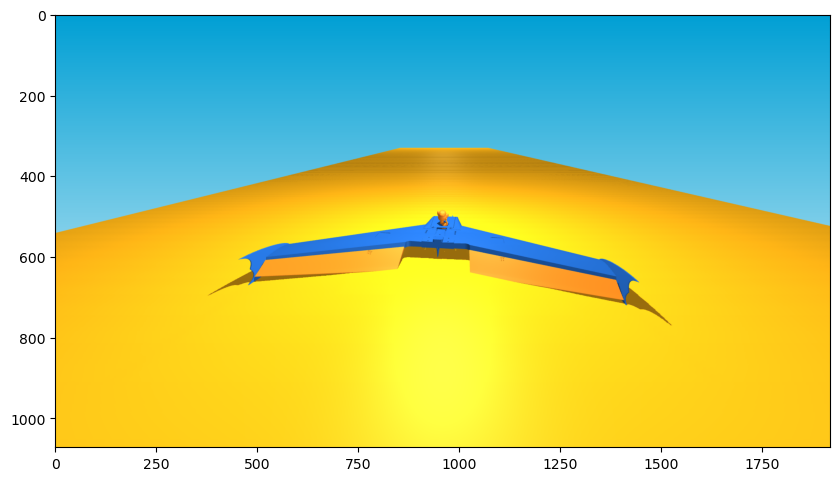

In [12]:
# Get snapshot as height x width x 4 numpy array of RGBA values
rgba = simulator.snapshot()

# Display snapshot
plt.figure(figsize=(10, 10))
plt.imshow(rgba)

# Save snapshot
plt.imsave('my_snapshot.png', rgba)

Plot the results.

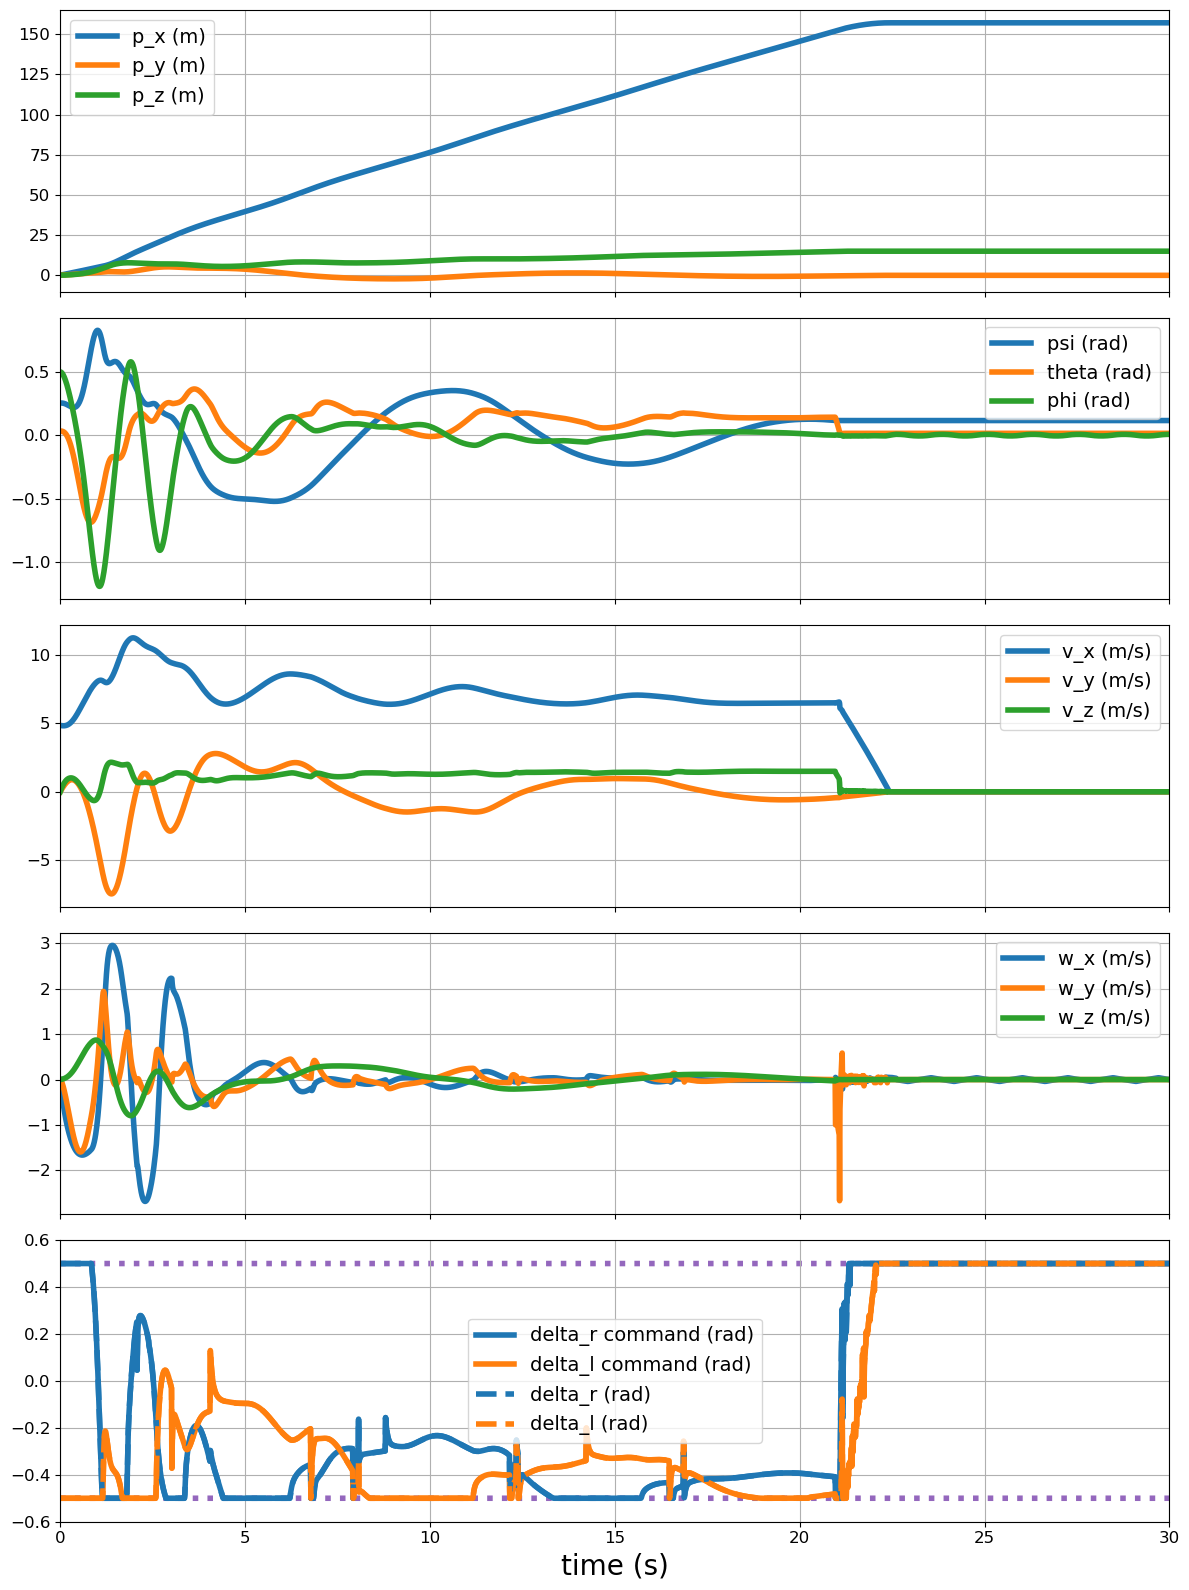

In [13]:
# Create a figure with five subplots, all of which share the same x-axis
fig, (
    ax_pos,
    ax_ori,
    ax_linvel,
    ax_angvel,
    ax_delta,
) = plt.subplots(5, 1, figsize=(12, 16), sharex=True)

# Plot position
ax_pos.plot(data['t'], data['p_x'], label='p_x (m)', linewidth=4)
ax_pos.plot(data['t'], data['p_y'], label='p_y (m)', linewidth=4)
ax_pos.plot(data['t'], data['p_z'], label='p_z (m)', linewidth=4)
ax_pos.grid()
ax_pos.legend(fontsize=14)
ax_pos.tick_params(labelsize=12)

# Plot orientation
ax_ori.plot(data['t'], data['psi'], label='psi (rad)', linewidth=4)
ax_ori.plot(data['t'], data['theta'], label='theta (rad)', linewidth=4)
ax_ori.plot(data['t'], data['phi'], label='phi (rad)', linewidth=4)
ax_ori.grid()
ax_ori.legend(fontsize=14)
ax_ori.tick_params(labelsize=12)

# Plot linear velocity
ax_linvel.plot(data['t'], data['v_x'], label='v_x (m/s)', linewidth=4)
ax_linvel.plot(data['t'], data['v_y'], label='v_y (m/s)', linewidth=4)
ax_linvel.plot(data['t'], data['v_z'], label='v_z (m/s)', linewidth=4)
ax_linvel.grid()
ax_linvel.legend(fontsize=14)
ax_linvel.tick_params(labelsize=12)

# Plot angular velocity
ax_angvel.plot(data['t'], data['w_x'], label='w_x (m/s)', linewidth=4)
ax_angvel.plot(data['t'], data['w_y'], label='w_y (m/s)', linewidth=4)
ax_angvel.plot(data['t'], data['w_z'], label='w_z (m/s)', linewidth=4)
ax_angvel.grid()
ax_angvel.legend(fontsize=14)
ax_angvel.tick_params(labelsize=12)

# Plot elevon deflection angles
ax_delta.plot(data['t'], data['delta_r_command'], label='delta_r command (rad)', linewidth=4)
ax_delta.plot(data['t'], data['delta_l_command'], label='delta_l command (rad)', linewidth=4)
ax_delta.plot(data['t'], data['delta_r'], '--', color='C0', label='delta_r (rad)', linewidth=4)
ax_delta.plot(data['t'], data['delta_l'], '--', color='C1', label='delta_l (rad)', linewidth=4)
ax_delta.plot(
    data['t'], -np.ones_like(data['t']) * simulator.maximum_elevon_deflection,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_delta.plot(
    data['t'], np.ones_like(data['t']) * simulator.maximum_elevon_deflection,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_delta.grid()
ax_delta.legend(fontsize=14)
ax_delta.tick_params(labelsize=12)
ax_delta.set_ylim(
    -1.2 * simulator.maximum_elevon_deflection,
    1.2 * simulator.maximum_elevon_deflection,
)

# Set x-axis properties (only need to do this on the last
# subplot since all subplots share the same x-axis)
ax_delta.set_xlabel('time (s)', fontsize=20)
ax_delta.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()

Save the figure (without transparent background).

In [14]:
fig.savefig('my_figure.png', facecolor='white', transparent=False)